# Multi-Layer Perceptron with MNIST handwritten digits classification 

## 1. Module Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.11.0  Device: cpu


## 3. MNIST 데이터 다운로드 (Train data와 Test data 분리하기)

In [4]:
BATCH_SIZE = 32

train_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)


## 4. torch.nn을 이용하여 모델 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!


In [5]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784,100)
        self.fc2 = nn.Linear(100,10)
        self.relu = nn.ReLU(inplace=True)
                    # ReLU class의 instance 만들기
    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x

## 6. 학습 준비하기

1) 모델 instance 만들기

2) Cross Entropy Loss 의 instance 만들기

3) torch.optim 준비 하고 Optimizier instance 만들기 (Stochastic Gradient Descent 방식)

4) 기타 상수 준비하기 (learning_rate 등)

In [6]:
import torch.optim as optim

network = Model()
print(network)

cls_loss =  nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
epoches = 20 # 마음대로 변경 가능함


Model(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [7]:
def training(train_loader):

    train_losses_per_epoch = []
    test_losses_per_epoch = []
    log_interval = 500
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
        
        train_losses = []
        test_losses = []
        train_correct = 0
        
        network.train()
        
        for batch_idx, (image, label) in enumerate(train_loader):
            # 미분값의 초기화
            optimizer.zero_grad()
            
            # 이미지를 (batch_size, 784) 차원의 메트릭스로 만드세요
            image = image.view(-1, 28 * 28)
            
            # Forward propagration 계산하기.
            outputs = network(image)
            
            # Cross_entropy 함수를 적용하여 loss를 구하고 저장하기
            loss = cls_loss(outputs,label)
            train_losses.append(loss.item())
            
            # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
            pred = torch.softmax(outputs,dim=1).max(1,keepdim=True)[1]
            train_correct += pred.eq(label.view_as(pred)).sum().item()

            # Gradinet 구하기
            loss.backward()

            # weight값 update 하기
            optimizer.step()
            
            # 학습 상황 출력
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                      .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                              loss.item()))
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            for batch_idx, (image, label) in enumerate(test_loader):
                image = image.view(-1, 28 * 28)

                # Forward propagration 계산하기.
                outputs = network(image)
                
                # Cross_entropy 함수를 적용하여 loss를 구하기
                loss = cls_loss(outputs,label)
                test_losses.append(loss.item())
 
                # Batch 별로 정확도 구하기
                pred = outputs.max(1,keepdim=True)[1]
                correct += pred.eq(label.view_as(pred)).sum().item()
        
            # 전체 정확도 구하기
            test_accuracy = 100. * correct / len(test_loader.dataset)
            
            #중간결과 출력
            print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
                  .format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [8]:
train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies = training(train_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.292937
Train Epoch: 0 [16000/60000 (27%)]	Loss: 1.219501
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.624498
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.327187

Training set: Accuracy: 46879/60000 (78%)
Test set: Accuracy: 8882/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.531678
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.536514
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.409628
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.224968

Training set: Accuracy: 53624/60000 (89%)
Test set: Accuracy: 9039/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.395094
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.432022
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.382628
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.203829

Training set: Accuracy: 54275/60000 (90%)
Test set: Accuracy: 9122/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.325096
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.382113
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.376318
Train Epoch: 3 [48000/60000

# 학습 결과 보기 
## 1. loss 값 비교

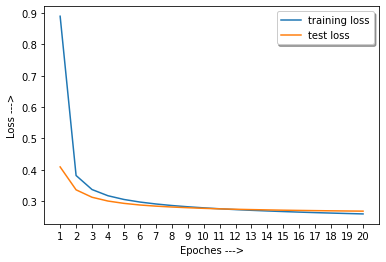

In [9]:
x = np.arange(1,epoches+1)
plt.plot(x,train_losses_per_epoch, x,test_losses_per_epoch)
plt.legend(('training loss', 'test loss'), loc='upper right', shadow=True)
plt.xlabel('Epoches --->')
plt.ylabel('Loss --->')
plt.xlim([0,21])
plt.xticks(np.arange(1, epoches+1, step=1))
plt.show()

# 2. 정확도 비교

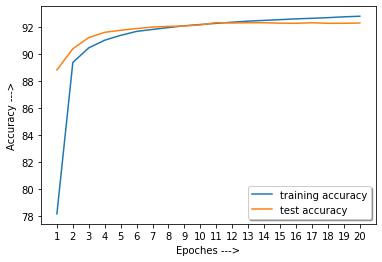

In [10]:
x = np.arange(1,epoches+1)
plt.plot(x, train_accuracies, x, test_accuracies)
plt.legend(('training accuracy', 'test accuracy'), loc='lower right', shadow=True)
plt.xlabel('Epoches --->')
plt.ylabel('Accuracy --->')
plt.xlim([0,21])
plt.xticks(np.arange(1, epoches+1, step=1))
plt.show()